<a href="https://colab.research.google.com/github/berkkorkmaz/deep-learning-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import pandas as pd
import math
import statistics
import pickle
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
CATEGORIES = ["Covid-19", "Normal", "Pneumonia-Bacteria",  "Pneumonia-Virus"]
DATADIR = "/content/drive/MyDrive/Colab Notebooks/project/data"

In [3]:
CATEGORIES = ["Covid-19", "Normal", "Pneumonia-Bacteria",  "Pneumonia-Virus"]

IMG_SIZE = 300

train_images = os.listdir(os.path.join(DATADIR,"train"))
test_images = os.listdir(os.path.join(DATADIR,"test"))
extra_covid_images = os.listdir(os.path.join(DATADIR,"COVID"))

data_summary = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/data/Chest_xray_Corona_dataset_Summary.csv")
data_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/data/Chest_xray_Corona_Metadata.csv")

# Arrays for training and test data 
training_data = []
test_data = []

def create_dataset(is_training):
    data_type = ["train"  if is_training else "test"][0]
    
    path = os.path.join(DATADIR, data_type)
    
    class_num = None  # get the classification for every category index
    
    for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
        for data in range(0, len(data_labels['Label'])):
            if img == data_labels['X_ray_image_name'][data] and data_labels['Dataset_type'][data].lower() ==data_type:
                if data_labels['Label'][data] == 'Normal':
                    class_num = CATEGORIES.index('Normal')
                elif data_labels['Label'][data] == 'Pnemonia':
                    pnemonia_category_1 = data_labels['Label_1_Virus_category'][data]
                    pnemonia_category_2 = data_labels['Label_2_Virus_category'][data]
                    if pnemonia_category_1 == 'bacteria':
                        class_num = CATEGORIES.index('Pneumonia-Bacteria')
                    if pnemonia_category_1 == 'Virus':
                        if pnemonia_category_2 == 'COVID-19':
                            class_num = CATEGORIES.index('Covid-19')
                        else:
                            class_num = CATEGORIES.index('Pneumonia-Virus')
        try:
            # Read the image from the folder by using OpenCv and convert to Grayscale
            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
            # Resize the images for normalization
            extracted_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            # Add extracted image to training or test arrays
            if data_type == "train":
                training_data.append([extracted_array, class_num])  # add this to our training_data
            else:
                test_data.append([extracted_array, class_num])  # add this to our test_data
        except Exception as e:  # in the interest in keeping the output clean...
            pass

create_dataset(True)  # Run the function for training data
create_dataset(False) # Run the function for test data

def create_extra_dataset(distribution=0.8):
    
    path = os.path.join(DATADIR, "COVID")
    class_num = CATEGORIES.index('Covid-19')
    
    training_images_number = int(distribution*len(os.listdir(path)))
    test_images_number = len(os.listdir(path)) - training_images_number
    
    image_index = 0    
    for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
        image_index += 1
        try:
            # Read the image from the folder by using OpenCv and convert to Grayscale
            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
            # Resize the images for normalization
            extracted_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            # Add extracted image to training or test arrays
            if image_index <= training_images_number:
                training_data.append([extracted_array, class_num])  # add this to our training_data
            else:
                test_data.append([extracted_array, class_num])  # add this to our test_data
        except Exception as e:  # in the interest in keeping the output clean...
            pass

create_extra_dataset(distribution=0.8) # Run the function for extra Covid dataset for both training and test



100%|██████████| 1200/1200 [00:07<00:00, 154.16it/s]


In [4]:
training_covid19_count = 0
training_normal_count = 0
training_pneumonia_virus = 0
training_pneumonia_bacteria = 0

for data_count in training_data:
    if data_count[1] == CATEGORIES.index('Covid-19'):
        training_covid19_count += 1
    elif data_count[1] == CATEGORIES.index('Normal'):
        training_normal_count += 1
    elif data_count[1] == CATEGORIES.index('Pneumonia-Virus'):
        training_pneumonia_virus += 1
    elif data_count[1] == CATEGORIES.index('Pneumonia-Bacteria'):
        training_pneumonia_bacteria += 1
        
print('Training ====> Covid-19: ', training_covid19_count,"---",'Normal: ', training_normal_count,"---", 
      'Pneumonia_Virus: ', training_pneumonia_virus,"---", 'Pneumonia_Bacteria: ', training_pneumonia_bacteria)


test_covid19_count = 0
test_normal_count = 0
test_pneumonia_virus = 0
test_pneumonia_bacteria = 0

for data_count in test_data:
    if data_count[1] == CATEGORIES.index('Covid-19'):
        test_covid19_count += 1
    elif data_count[1] == CATEGORIES.index('Normal'):
        test_normal_count += 1
    elif data_count[1] == CATEGORIES.index('Pneumonia-Virus'):
        test_pneumonia_virus += 1
    elif data_count[1] == CATEGORIES.index('Pneumonia-Bacteria'):
        test_pneumonia_bacteria += 1
        
print('Test ====> Covid-19: ', test_covid19_count,"---", 'Normal: ', test_normal_count,"---", 
      'Pneumonia_Virus: ', test_pneumonia_virus,"---", 'Pneumonia_Bacteria: ', test_pneumonia_bacteria)

Training ====> Covid-19:  1018 --- Normal:  1346 --- Pneumonia_Virus:  1356 --- Pneumonia_Bacteria:  2549
Test ====> Covid-19:  240 --- Normal:  234 --- Pneumonia_Virus:  148 --- Pneumonia_Bacteria:  242


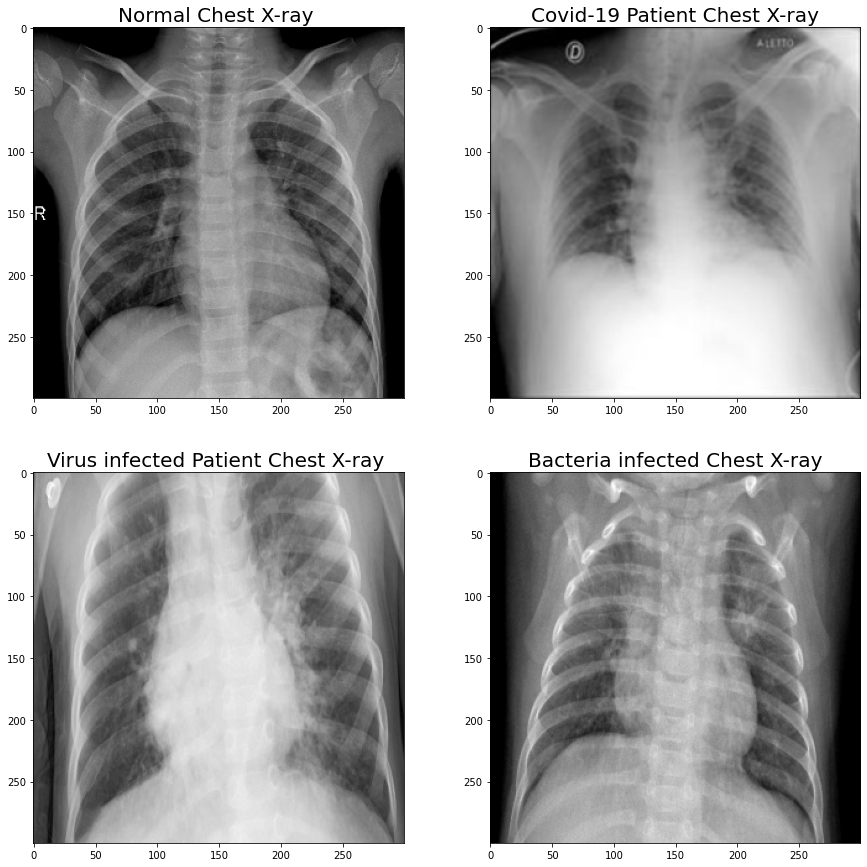

In [6]:
# importing the random module
import random

covid19_image, normal_image, pneumonia_virus_image, pneumonia_bacteria_image = 0, 0, 0, 0
while True:
    data = random.randint(0,len(training_data))
    if covid19_image == 0:
        if training_data[data][1] == CATEGORIES.index('Covid-19'):
            covid19_image = data
    if normal_image == 0:
        if training_data[data][1] == CATEGORIES.index('Normal'):
            normal_image = data
        if training_data[data][1] == CATEGORIES.index('Pneumonia-Virus'):
            pneumonia_virus_image = data
    if pneumonia_bacteria_image == 0:
        if training_data[data][1] == CATEGORIES.index('Pneumonia-Bacteria'):
            pneumonia_bacteria_image = data
    if min(covid19_image, normal_image, pneumonia_virus_image, pneumonia_bacteria_image)!= 0:
        break

plt.figure(figsize=(15, 15));

### Plotting the Normal Patient X-ray Chest Image
plt.subplot(2, 2, 1); plt.title('Normal Chest X-ray ',fontsize=20);
plt.imshow(training_data[normal_image][0], cmap='gray')  # graph it

### Plotting the Normal Patient X-ray Chest Image
plt.subplot(2, 2, 2); plt.title("Covid-19 Patient Chest X-ray",fontsize=20);
plt.imshow(training_data[covid19_image][0], cmap='gray')  # graph it

### Plotting the Normal Patient X-ray Chest Image
plt.subplot(2, 2, 3); plt.title('Virus infected Patient Chest X-ray ',fontsize=20);
plt.imshow(training_data[pneumonia_virus_image][0], cmap='gray')  # graph it

### Plotting the Normal Patient X-ray Chest Image
plt.subplot(2, 2, 4); plt.title("Bacteria infected Chest X-ray",fontsize=20);
plt.imshow(training_data[pneumonia_bacteria_image][0], cmap='gray')  # graph it


In [7]:
# Data is shuffled randomly
random.shuffle(training_data)
random.shuffle(test_data)
# Arrays for training and test data for both features and labels
training_X = [];training_y = [];test_X = [];test_y = []
for features,label in training_data:
    training_X.append(features)
    training_y.append(label)

for features,label in test_data:
    test_X.append(features)
    test_y.append(label)
    
# Arrays are converted to numpy arrays to be used
training_y = np.array(training_y)
test_y = np.array(test_y)

training_X = np.array(training_X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_X = np.array(test_X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [8]:
import pickle

pickle_out = open("/content/drive/MyDrive/Colab Notebooks/project/training_X.pickle","wb")
pickle.dump(training_X, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/Colab Notebooks/project/training_y.pickle","wb")
pickle.dump(training_y, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/Colab Notebooks/project/test_y.pickle","wb")
pickle.dump(test_y, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/Colab Notebooks/project/test_X.pickle","wb")
pickle.dump(test_X, pickle_out)
pickle_out.close()

In [9]:
import pickle

IMG_SIZE = 300

pickle_in = open("/content/drive/MyDrive/Colab Notebooks/project/training_X.pickle","rb")
trn_X = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/MyDrive/Colab Notebooks/project/training_y.pickle","rb")
trn_y = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/MyDrive/Colab Notebooks/project/test_X.pickle","rb")
tst_X = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open("/content/drive/MyDrive/Colab Notebooks/project/test_y.pickle","rb")
tst_y = pickle.load(pickle_in)
pickle_in.close()

trn_X = trn_X/255.0

trn_X = np.array(trn_X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

trn_y = np.array(trn_y)

tst_X = tst_X/255.0

tst_X = np.array(tst_X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

tst_y = np.array(tst_y)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model

In [11]:
encoder = LabelBinarizer()
trn_y_t = encoder.fit_transform(trn_y)
tst_y_t = encoder.transform(tst_y)

input_shape=trn_X.shape[1:]


model=Sequential()

model.add(Conv2D(64,kernel_size=(3,3),activation="relu",input_shape=input_shape))
model.add(MaxPooling2D(pool_size = (3,3)))
# model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

In [13]:
model.fit(trn_X, 
          trn_y_t,
          batch_size=32,
          epochs=5,
          validation_steps = 4,
          validation_data=(tst_X, tst_y_t))

model.save('/content/drive/MyDrive/Colab Notebooks/project/model')

Epoch 1/5
196/196 [==============================] - 695s 4s/step - loss: 0.9944 - accuracy: 0.5540 - val_loss: 0.7606 - val_accuracy: 0.7656
Epoch 2/5
196/196 [==============================] - 675s 3s/step - loss: 0.5939 - accuracy: 0.7594 - val_loss: 0.6760 - val_accuracy: 0.7422
Epoch 3/5
196/196 [==============================] - 670s 3s/step - loss: 0.5275 - accuracy: 0.7902 - val_loss: 0.6910 - val_accuracy: 0.7578
Epoch 4/5
196/196 [==============================] - 672s 3s/step - loss: 0.4794 - accuracy: 0.8017 - val_loss: 0.7493 - val_accuracy: 0.8047
Epoch 5/5
196/196 [==============================] - 671s 3s/step - loss: 0.4474 - accuracy: 0.8043 - val_loss: 0.7200 - val_accuracy: 0.7109
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/project/model/assets


In [15]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/project/model')

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0

In [75]:
score = model.evaluate(tst_X, tst_y_t, verbose=1)
y_pred = new_model.predict(tst_X)

27/27 [==============================] - 26s 954ms/step - loss: 0.7908 - accuracy: 0.7488


In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Conversion for accuracy calculations
tst_y_converted = []
for i in range(tst_y_t.shape[0]):
  tst_y_converted.append(np.argmax(tst_y_t[i]))

tst_y_converted = np.asarray(tst_y_converted)
y_pred = np.argmax(y_pred, axis=1)
# metrics
precision = precision_score(tst_y_converted, y_pred, average='weighted')
recall = recall_score(tst_y_converted, y_pred, average='weighted')
f1 = f1_score(tst_y_converted, y_pred, average="weighted")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Precision:  0.800364484388554
Recall:  0.7488425925925926
F1:  0.737377443669517
